**Lucas Romero Fernández, June 2025**

# Objective

Try out these sampling algorithms:
1. Standard Metropolis-Hastings MCMC (M-H MCMC)
3. Affine-invariant ensemble MCMC (emcee)
4. Hamiltonian MCMC

On the following 3 example target distributions:
1. A single bivariate Gaussian
2. A double bivariate Gaussian
3. The anisotropic distribution defined in Eq. 2 of the Foreman-Mackey + 2013 emcee paper (https://arxiv.org/abs/1202.3665)

Each with distinct properties and challenges for the various sampling algorithms.
# Indications

You can either implement each algorithm yourself (following a reference, e.g. the P. Mann blog, referenced properly later in this code), utilize the packages https://pypi.org/project/emcee/ with https://emcee.readthedocs.io/en/latest/tutorials/quickstart/), their versions wrapped in the common Bilby interface https://pypi.org/project/bilby/ (with https://lscsoft.docs.ligo.org/bilby/examples.html) or some equivalents.

Since different packages may require the target distribution and other parameters defined in various ways, it is attached as an example two ways of writing them. The first form for each distribution is the PDF with x,y given separately as the sampling variables and the mean/var/eps parameters of each distribution (the "true values") hardcoded. The second equivalent form is instead the log-PDF, as the emcee package expects them, a single 2-entry list for the sampling variables (it is also essential to specify "ndim = 2"), and with the "true values" explicitly included as function parameters.

Typical things to plot and check after running a sampler:

* 2D scatter / contour plot of the posterior samples
* 1D histograms and trace plots for each parameter
* Autocorrelation plots

Again, some examples can be seen in the the P. Mann blog, but note that the matplotlib.mlab.bivariate_normal and the sns.tsplot functions used there no longer exist in current package versions (the simplest replacement for a trace plot is simply plt.plot(x) and the running average and "true value" dashed line seen in the plots are optional). If you use existing packages, they also have some built-in plotting and convergence test functions that can be utilized.

Some tips for the computation and verification of the results:

* For the standard M-H MCMC, the example from the P. Mann blog has a proposal distribution that will be sufficient for the first 2 targets; it is not recommended to spend much time trying to optimize that. It can also be tested with 500 steps first to see how it runs, but it is likely necessary to go higher to obtain meaningful results. Don't worry if the third case looks poor for this simple sampler (almost no accepted samples), that's the point!
* For emcee, 128 walkers seem to be a solid starting point, 1000 steps is generally sufficient to get nice posterior plots, but will still encounter an error when calling get_autocorr_time() due to insufficient length; so extra steps may be needed.

Additional Python tips:

* To set up a virtual environment, e.g. for Bilby, and to enable it for Jupyter notebooks, see lecture slides. (key line: "ipythonkernel install --user --name=bilby-test")
* Another useful package for plotting is "corner", which can be installed the normal pip method.

# Results

## Libraries utilized

To begin, all the necessary libraries are imported into the program to provide the essentials for future computations.

In [18]:
import numpy as np # For operations with numbers
import scipy.stats as st # For the log_probs
import matplotlib.pyplot as plt # For plotting
import corner # For corner plots
import emcee # For the emcee sampler
import tqdm # To display progress bars
import time # For time recording
from pyhmc import hmc # For the Hamiltonian Monte Carlo

## General configurations and definitions of constants, variables, arrays and functions

Next, beginning the main preparation part, some universal configurations are implemented, such as setting the random seed to ensure, at least, minimal convergence to equivalent results in different attempts, as well as defining the general NumPy autocorrelation and cross correlation functions [1] between samples (with the means subtracted) and a common plot-making function with corner plots [2] deployed for every example distribution and sampling algorithm (except emcee).

Following this, the three different difficulty-increasing example distributions are prepared in two ways, the "simple" PDF (Probability Density Function) one and the logarithmic PDF one. Specifically, the first example distribution, corresponding to a single bivariate ($\mathbf{x} = (x,y)$) Gaussian, adopts a multivariate normal distribution whose PDF is generally expressed as [3]: $$f(\mathbf{x},\mu,\Sigma,k) = \frac{1}{\sqrt{(2\pi)^{k}\mathrm{det}(\Sigma)}}e^{-\frac{1}{2}(\mathbf{x} - \mu)^{T}\Sigma^{-1}(\mathbf{x} - \mu)},$$ where $\mu$ is the mean, $\Sigma$ is the positive-definite covariance matrix, $k$ is the rank of $\Sigma$ ($k = 2$ in this exercise), $\mathrm{det}$ indicates the determinant of the corresponding matrix, and $^{T}$ denotes the transpose of the respective matrix. The second example distribution, a double bivariate Gaussian, is a combination of two single bivariate Gaussians, with differing $\mu$, $\Sigma$ , and $k$ (generally), which can be conveyed broadly in the following manner: $$g(\mathbf{x},\mu_{1},\mu_{2},\Sigma_{1},\Sigma_{2},k_{1},k_{2}) = f(\mathbf{x},\mu_{1},\Sigma_{1},k_{1}) + f(\mathbf{x},\mu_{2},\Sigma_{2},k_{2}).$$ Lastly, the third example distribution, an extremely narrow Gaussian anisotropic distribution taken from Eq.2 of [4], which, in this case, it has the algebraic form of: $$p(\mathbf{x}) = e^{-\frac{(x - y)^{2}}{2\epsilon} - \frac{(x + y)^{2}}{2}},$$ where $\epsilon$ is typically of small magnitude.

Finally, all the different testing sampling algorithms with their corresponding plots ("samplers"), are implemented. Starting with the basic M-H MCMC, it is manually written using [5] and [6], ignoring burn-in steps (to focus on the study of its results without them) and the proposal distribution in the acceptance ratio (due to only using symmetric proposal distributions). Next, the emcee sampling algorithm, introduced in [4], is integrated in the program using the python module *emcee* [7] for convenience reasons, and, therefore, the plot-making function is specifically modified to accommodate its needs, with the help of [8] due to the increased complexity and number of walkers. Lastly, the Hamiltonian MCMC, first appearing in [9], is tested using the function *hmc* of the Python module *pyhmc* [10] for simplicity; consequently, the target distribution functions are modified to include the numerical computation of the gradient for correct implementation (if needed, refer to [11] for a conceptual introduction).

In [2]:
# Random seed setting (to always have the same random result)
np.random.seed(1457)
rng = np.random.RandomState(1457)
def autocorr(x_array):
    """
    Autocorrelations function with the values in the x_array.
    """
    x_array2 = x_array - x_array.mean()
    res = np.correlate(x_array2,x_array2,mode = "full")
    return res[res.size//2:]/float(res.max())
def crosscorr(x_array,y_array): 
    """
    Cross correlations function with the values in x_array 
    and y_array.
    """
    x_array2 = x_array - x_array.mean() 
    y_array2 = y_array - y_array.mean() 
    res = np.correlate(x_array2,y_array2,mode = "full") 
    return res[res.size//2:]/float(res.max())
def plot_maker(samples,num_samples,max_lag): 
    """ 
    General function that generates a 2D scatter + contour, 
    trace and auto/cross correlations corner plots for the 
    corresponding sampler and distribution.
    
    Parameters:
    samples: array or list 
        Array/List with the first two columns containing the
        samples to be plotted.
    num_samples: int
        Number of samples to use.
    max_lag: int 
        Maximum lag until which to plot the autocorrelations.

    Returns:
    Plots for the corresponding sampler and distribution.
    """
    # 2D scatter + contour plots 
    cornerfig,ax = plt.subplots(2,2,figsize = (10,7))
    figure = corner.corner(
        data = samples,
        fig = cornerfig,
        bins = 50,
        labels = [r"$x$",r"$y$"],
        show_titles = True,
    )
    plt.show()
    # Trace and correlation plots
    fig,axs = plt.subplots(2,2,figsize = (12,8))
    # Traces 
    axs[0,0].plot(samples[:,0],"black")
    axs[0,0].set_title("Trace plots")
    axs[0,0].set_xlim(0,num_samples)
    axs[0,0].set_ylabel("$x$")
    axs[1,0].plot(samples[:,1],"black")
    axs[1,0].set_xlim(0,num_samples)
    axs[1,0].set_xlabel("Samples")
    axs[1,0].set_ylabel("$y$") 
    # Correlations 
    axs[0,1].set_title("Normalized autocorrelations")
    axs[0,1].plot(
        autocorr(np.array(samples[:,0])),
        color = "black",
        label = "$x$"
    )
    axs[0,1].plot(
        autocorr(np.array(samples[:,1])),
        color = "red",
        label = "$y$"
    )
    axs[0,1].set_xlim(-1,max_lag)
    axs[0,1].legend()
    axs[1,1].set_title("Normalized cross correlations")
    axs[1,1].plot(
        crosscorr(np.array(samples[:,0]),np.array(samples[:,1])),
        color = "black"
    )
    axs[1,1].set_xlim(-1,max_lag)
    axs[1,1].set_xlabel("Lag")
    plt.show()
### Similar code given for the different distributions
# 1st target distribution
mean = np.array([0,1])
var = np.array([[1,.5],[.5,1]])
def ptarget1(x,y): 
    """the distribution we wish to sample""" 
    return st.multivariate_normal.pdf([x,y],mean = mean,cov = var) 
def log_prob1(x,mean,var): 
    """equivalent to ptarget1() in logarithmic form""" 
    return st.multivariate_normal.logpdf(x,mean = mean,cov = var) 
# 2nd target distribution
mean1 = np.array([0,1])
var1 = np.array([[1,.5], [.5,1]])
mean2 = np.array([-4,-4])
var2 = var1
def ptarget2(x,y): 
    """double Gaussian""" 
    return 0.5*(
        st.multivariate_normal.pdf([x,y],mean = mean1,cov = var1)
        + st.multivariate_normal.pdf([x,y],mean = mean2,cov = var2)
    )
def log_prob2(x,mean1,var1,mean2,var2):
    """equivalent to ptarget2() in logarithmic form""" 
    return np.log(0.5*(
        st.multivariate_normal.pdf(x,mean = mean1,cov = var1)
        + st.multivariate_normal.pdf(x,mean = mean2,cov = var2)
    ))
# 3rd target distribution
eps = np.array([1e-6]) 
def ptarget3(x,y): 
    """very anistropic distribution from [3], Eq. 2""" 
    return np.exp(-(x - y)**2/(2*eps) - (x + y)**2/2) 
def log_prob3(x,eps):
    """equivalent to ptarget3() in logarithmic form"""
    return -(x[0] - x[1])**2/(2*eps) - (x[0] + x[1])**2/2
###
# Standard Metropolis Hastings MCMC algorithm
def metropolis_hastings_alg(dist_func,init_state,num_samples,prop_std): 
    """ 
    Runs standard Metropolis Hastings MCMC algorithm for a chosen 
    distribution. 
    
    Parameters: 
    dist_func: function 
        Distribution used for the sampling. 
    init_state: array 
        Initial position to start the sampling. 
    num_samples: int 
        Number of samples to use. 
    prop_std: float 
        Proposal standard deviation (using np.random.normal).
    
    Returns: 
    np.array(samples): array 
        Numpy array with the samples ordered in columns. 
    final_accept_ratio: float 
        Final acceptance ratio of the proposals.
    """
    samples = [init_state] 
    curr_state = init_state 
    acceptance = 0 
    t0 = time.time()
    for _ in tqdm.tqdm(range(num_samples)): # Progress bar
        # Proposal of a new candidate state
        cand_state = curr_state + np.random.normal(
            scale = prop_std,
            size = curr_state.shape
        ) 
        # Computation of the acceptance ratio 
        acceptance_ratio = min(
            1,
            dist_func(*cand_state)/dist_func(*curr_state)
        ) 
        # Acceptance or rejection of the candidate state
        if np.random.uniform() < acceptance_ratio: 
            curr_state = cand_state
            acceptance += 1 
        samples.append(curr_state)
    tf = time.time()
    t_samp = tf - t0 # Sampling time 
    final_accept_ratio = acceptance/num_samples
    print(f"Results:")
    print(f"Sampling time: {t_samp} s") 
    print(f"Sampling time per sample: {t_samp/num_samples} s/sample") 
    print(f"Sampling time per sample & acceptance ratio: "
          f"{
          t_samp/(num_samples*final_accept_ratio)
          } s/(sample*acceptance_ratio)") 
    return np.array(samples),final_accept_ratio
def metropolis_hastings_samp(func,init_state,num_samples,prop_std,max_lag): 
    """ 
    Performs the standard Metropolis-Hastings MCMC sampling and the 
    corresponding plots for the pertinent distribution/function "func" 
    using the recurring variables already exposed.
    """ 
    print(f"Starting standard Metropolis-Hastings MCMC sampling...")
    print(f"Sampled function: {func}")
    print(f"Initial position: {init_state}")
    print(f"Number of samples: {num_samples}")
    print(f"Proposal standard deviation: {prop_std}")
    print(f"Running sampling...")
    # Metropolis-Hastings MCMC algorithm computation 
    samples,final_accept_ratio = metropolis_hastings_alg(
        func,
        init_state,
        num_samples,
        prop_std,
    )
    print(f"Acceptance ratio: {final_accept_ratio}") 
    print(f"Generating plots...")
    plot_maker(samples,num_samples,max_lag)
def plot_maker_emcee(samples,steps,max_lag,num_walkers): 
    """ 
    Function that generates a 2D scatter + contour, trace and auto/cross 
    correlations corner plots for the emcee sampler specifically and the 
    corresponding distribution.
    
    Parameters: 
    samples: array or list 
        Array/List with the first two columns containing the samples to 
        be plotted.
    steps: int
        Number of steps to use.
    max_lag: int 
        Maximum lag until which to plot the autocorrelations. 
    num_walkers: int
        Number of walkers to use.
        
    Returns: 
    Plots for the emcee sampler and the corresponding distribution. 
    """
    # 2D scatter + contour plot
    cornerfig, ax = plt.subplots(2,2,figsize=(10,7)) 
    figure = corner.corner(
        data = samples,
        fig = cornerfig,
        bins = 50,
        labels = [r"$x$",r"$y$"], 
        show_titles=True,
    )
    plt.show() 
    # Trace and autocorrelation plots
    fig,axs = plt.subplots(2,2,figsize = (12,8))
    for walker in range(num_walkers): # A plot for each walker
        samples_x_walker = [
            samples[:,0][i + walker] for i in range(
                1,len(samples[:,0]) - walker,num_walkers
            )
        ]
        axs[0,0].plot(samples_x_walker,alpha = 0.4)
        samples_y_walker = [
            samples[:,1][i + walker] for i in range(
                1,len(samples[:,0]) - walker,num_walkers
            )
        ] 
        axs[1,0].plot(samples_y_walker,alpha = 0.4)
        axs[0,1].plot(
            autocorr(np.array(samples_x_walker)),
            color = "black",
            alpha = 0.5
        ) 
        axs[0,1].plot(
            autocorr(np.array(samples_y_walker)),
            color = "red",
            alpha = 0.5
        ) 
        axs[0,1].legend(["$x$","$y$"]) 
        axs[1,1].plot(
            crosscorr(np.array(samples_x_walker),np.array(samples_y_walker)),
            color = "black",
            alpha = 0.5
        ) 
    axs[0,0].set_title("Trace plots")
    axs[0,0].set_xlim(0,steps)
    axs[0,0].set_ylabel("$x$") 
    axs[1,0].set_ylabel("$y$")
    axs[1,0].set_xlim(0,steps)
    axs[1,0].set_xlabel("Steps") 
    axs[0,1].set_title("Normalized autocorrelations")  
    axs[0,1].set_xlim(-1,max_lag) 
    axs[1,1].set_title("Normalized cross correlations")  
    axs[1,1].set_xlim(-1,max_lag) 
    axs[1,1].set_xlabel("Lag")
    plt.show()
def emcee_samp(log_prob_func,args,ndim,num_walkers,burn_in_steps,steps,max_lag): 
    """
    Performs the emcee.EnsembleSampler sampling and the corresponding plots for 
    the pertinent probability function in logarithmic form "log_prob_func",
    with number of dimensions "ndim", burn-in steps "burn_in_steps" and number 
    of steps "steps".
    """  
    p0 = np.random.rand(num_walkers,ndim) # Initial state and covariance 
    print(f"Starting affine-invariant ensemble MCMC (emcee) sampling...") 
    print(f"Sampled function: {log_prob_func}") 
    print(f"Number of walkers: {num_walkers}")
    print(f"Number of burn in steps: {burn_in_steps}") 
    print(f"Number of steps: {steps}")
    print(f"Running sampling...")
    t0 = time.time()
    # Emcee algorithm computation
    sampler = emcee.EnsembleSampler(num_walkers,ndim,log_prob_func,args = args)
    # Performance of the burn-in steps
    state = sampler.run_mcmc(p0,burn_in_steps)
    sampler.reset() 
    # Actual sampling computation
    t0 = time.time()
    sampler.run_mcmc(state,steps)
    samples = sampler.get_chain(flat = True)
    tf = time.time()
    t_samp = tf - t0 # Sampling time
    print(f"Results:")
    print(f"Sampling time: {t_samp} s")
    print(f"Sampling time per step: {t_samp/steps} s/step") 
    print("Mean acceptance ratio: {0:.3f}".format(np.mean(sampler.acceptance_fraction))) 
    try: 
        autocorr_time = np.mean(sampler.get_autocorr_time()) 
        print("Mean autocorrelation time: {0:.3f} steps".format(autocorr_time)) 
    except: 
        print(f"Mean autocorrelation time could not be computed")
    print(f"Generating plots...")
    plot_maker_emcee(samples,steps,max_lag,num_walkers)
### Similar code given for the different distributions (for the HMC sampling)
step_size = 0.001
def gradlogp(x_array,func,args):
    """ 
    Function that performs the gradient numerically, using finite differences,
    for the corresponding distribution function and walker. 
    
    Parameters: 
    x_array: 2D array
        Current position of the walker. 
    func: function 
        Distribution function. 
    args: arguments 
        Arguments for the distribution function.
    
    Returns:
    array 
        The numerically computed gradient. 
    """ 
    return np.array([
        (
            func(
                [x_array[0] + step_size,x_array[1]],*args
            ) - func(
                [x_array[0] - step_size,x_array[1]],*args
            )
        )/(2*step_size),
        (
            func(
                [x_array[0],x_array[1] + step_size],*args
            ) - func(
                [x_array[0],x_array[1] - step_size],*args)
        )/(2*step_size)
    ])
# 1st target distribution
def log_prob1_hmc(x,mean,var):
    """equivalent to ptarget1() in logarithmic form for the HMC sampling"""
    func = st.multivariate_normal.logpdf 
    logp = func(x,mean = mean,cov = var) 
    grad = gradlogp(x,func,args = (mean,var)) 
    return logp,grad 
# 2nd target distribution
def log_prob2_hmc(x,mean1,var1,mean2,var2):
    """equivalent to ptarget2() in logarithmic form for the HMC sampling"""
    func = log_prob2 
    logp = func(x,mean1,var1,mean2,var2) 
    grad = gradlogp(x,func,args = (mean1,var1,mean2,var2)) 
    return logp,grad 
# 3rd target distribution
eps_hmc = 1e-6
def log_prob3_hmc(x,eps,):
    """equivalent to ptarget3() in logarithmic form for the HMC sampling"""
    func = log_prob3
    logp = func(x,eps,)
    grad = gradlogp(x,func,args = (eps,)) 
    return logp,grad
###
def hmc_samp(log_prob_func,init_state,args,num_samples,epsilon,max_lag):
    """ 
    Performs the Hamiltonian MCMC sampling and the corresponding plots
    for the pertinent distribution/function in logarithmic form 
    "log_prob_func" using the recurring variables already exposed. 
    """ 
    print(f"Starting Hamiltonian MCMC sampling...") 
    print(f"Sampled function: {log_prob_func}") 
    print(f"Initial position: {init_state}") 
    print(f"Number of samples: {num_samples}") 
    print(f"Step adjustment in integrator: {epsilon}")
    print(f"Running sampling...")
    t0 = time.time() 
    # Hamiltonian MCMC sampling computation
    samples = hmc(
        log_prob_func,
        x0 = init_state,
        args = args,
        n_samples = num_samples,
        epsilon = epsilon,
        display = False
    )
    tf = time.time() 
    t_samp = tf - t0 # Sampling time
    print(f"Results:")
    print(f"Sampling time: {t_samp} s") 
    print(f"Sampling time per sample: {t_samp/num_samples} s/sample") 
    print(f"Generating plots...") 
    plot_maker(samples,num_samples,max_lag)

## main_program

### Target distributions plots

For better visualization and understanding, the following plots show the different example distributions to be tested with the three different sampling algorithms, increasing in sampling complexity and challenge from left to right:

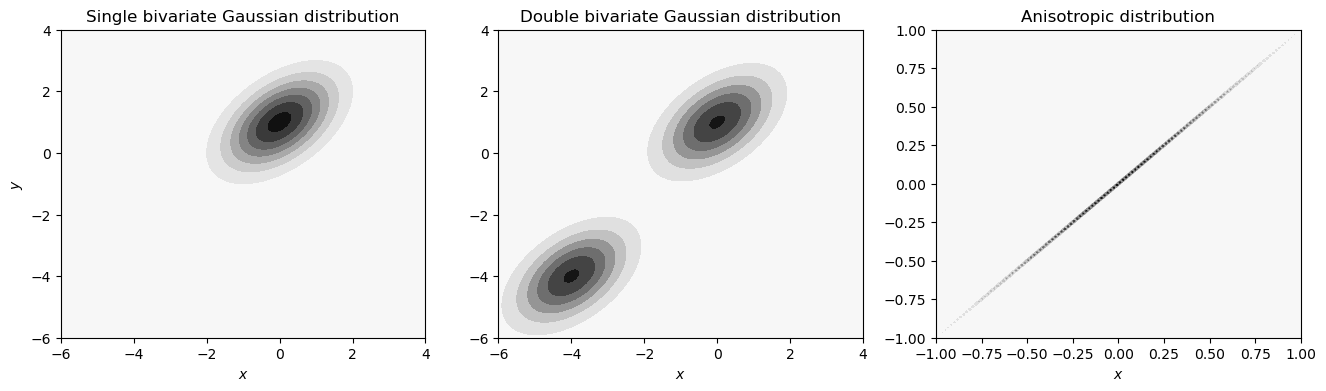

In [3]:
grid_points = 120
x_grid_array = np.linspace(-6,4,grid_points)
y_grid_array = np.linspace(-6,4,grid_points)
x_grid_array2 = np.linspace(-1,1,grid_points)
y_grid_array2 = np.linspace(-1,1,grid_points)
z_grid_array1 = np.zeros([grid_points,grid_points])
z_grid_array2 = np.zeros([grid_points,grid_points])
z_grid_array3 = np.zeros([grid_points,grid_points])
for i,x in enumerate(x_grid_array): 
    for j,y in enumerate(y_grid_array): 
        z_grid_array1[j,i] = ptarget1(x,y)
        z_grid_array2[j,i] = ptarget2(x,y)
for i,x in enumerate(x_grid_array2):
    for j,y in enumerate(y_grid_array2):
        z_grid_array3[j,i] = ptarget3(x,y)[0]
fig, axs = plt.subplots(1,3,figsize = (16,4))
axs[0].set_title("Single bivariate Gaussian distribution")
axs[0].contourf(x_grid_array,y_grid_array,z_grid_array1,cmap = "Greys")
axs[0].set_ylabel("$y$")
axs[0].set_xlabel("$x$")
axs[1].set_title("Double bivariate Gaussian distribution")
axs[1].contourf(x_grid_array,y_grid_array,z_grid_array2,cmap = "Greys")
axs[1].set_xlabel("$x$")
axs[2].set_title("Anisotropic distribution")
axs[2].contourf(x_grid_array2,y_grid_array2,z_grid_array3,cmap = "Greys")
axs[2].set_xlabel("$x$")
plt.show()

## Standard Metropolis-Hastings MCMC algorithm

Now, the testing with the different algorithm samplings can begin with the simple standard Metropolis-Hastings MCMC method, taking into account that the proposals are general normal distributions with $\mu = 0$ and standard deviation (std) $\sigma = 1$ to minimally influence the outcome, and that that the initial positions (or initial states) have been chosen to be slightly off from the center of the distributions in order to observe the time it takes for the walkers to converge to the relevant area.

### Single bivariate Gaussian case

Starting standard Metropolis-Hastings MCMC sampling...
Sampled function: <function ptarget1 at 0x000001EC3BDF9EE0>
Initial position: [-4  4]
Number of samples: 20000
Proposal standard deviation: 1.0
Running sampling...


100%|██████████| 20000/20000 [00:03<00:00, 5923.35it/s]


Results:
Sampling time: 3.380714178085327 s
Sampling time per sample: 0.00016903570890426637 s/sample
Sampling time per sample & acceptance ratio: 0.0003323549132997765 s/(sample*acceptance_ratio)
Acceptance ratio: 0.5086
Generating plots...


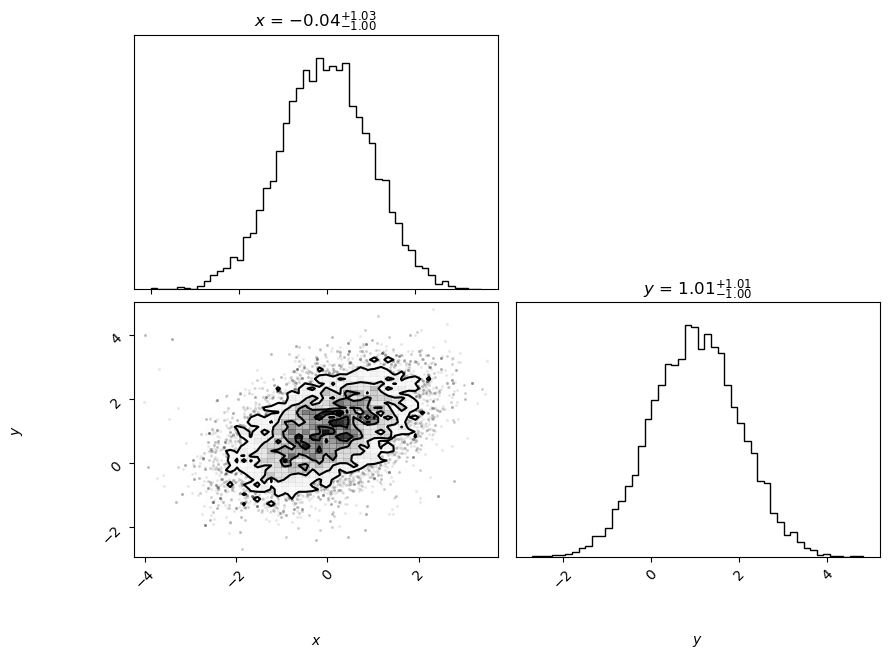

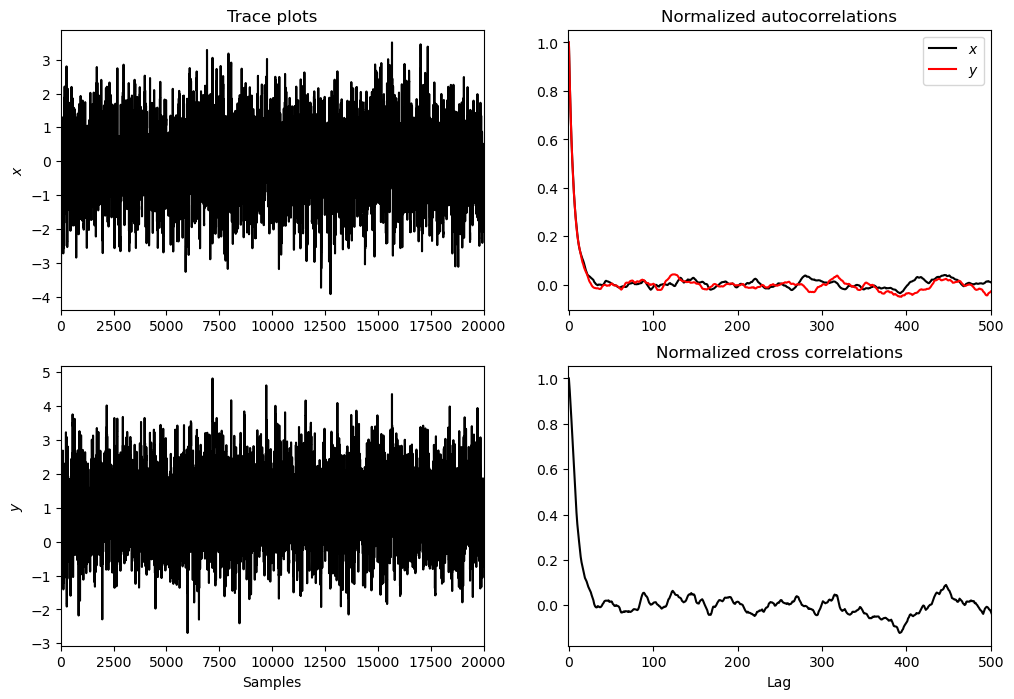

In [4]:
metropolis_hastings_samp(
    func = ptarget1,
    init_state = np.array([-4,4]),
    num_samples = 20000,
    prop_std = 1.0,
    max_lag = 500
)

As could be expected, even this simple and computationally fast algorithm can sample this trivial distribution with ease, converging extremely fast to the main focus zone (even with a slightly unfavorable initial state), with autocorrelations and cross correlations decreasing quickly as the lag increases and a reasonable acceptance ratio of $\approx 0.5$ [5].

### Double bivariate Gaussian case

Starting standard Metropolis-Hastings MCMC sampling...
Sampled function: <function ptarget2 at 0x000001EC3BDF9C60>
Initial position: [ 2 -6]
Number of samples: 20000
Proposal standard deviation: 1.0
Running sampling...


100%|██████████| 20000/20000 [00:06<00:00, 2858.22it/s]


Results:
Sampling time: 7.000344753265381 s
Sampling time per sample: 0.00035001723766326905 s/sample
Sampling time per sample & acceptance ratio: 0.0006719470870863295 s/(sample*acceptance_ratio)
Acceptance ratio: 0.5209
Generating plots...


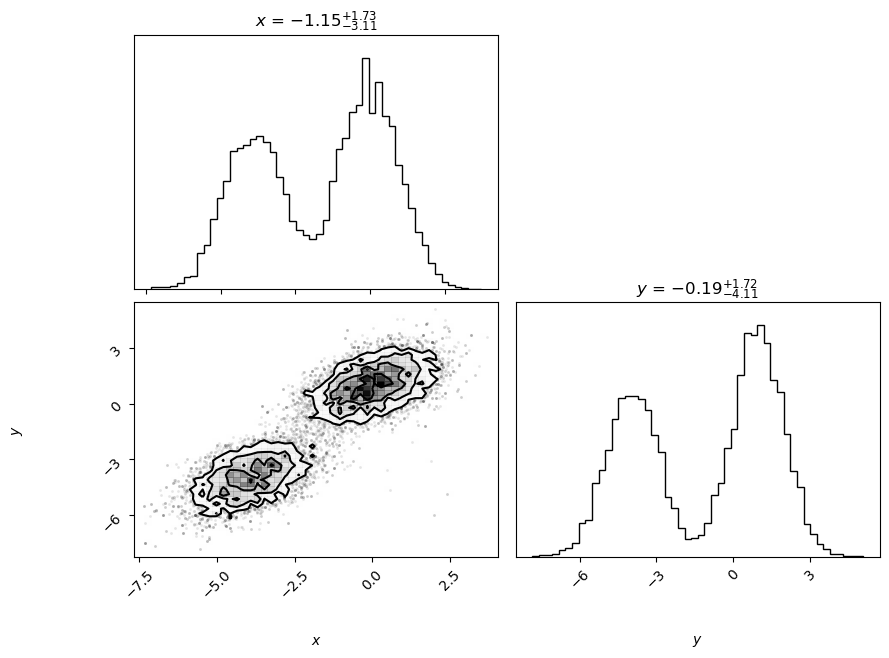

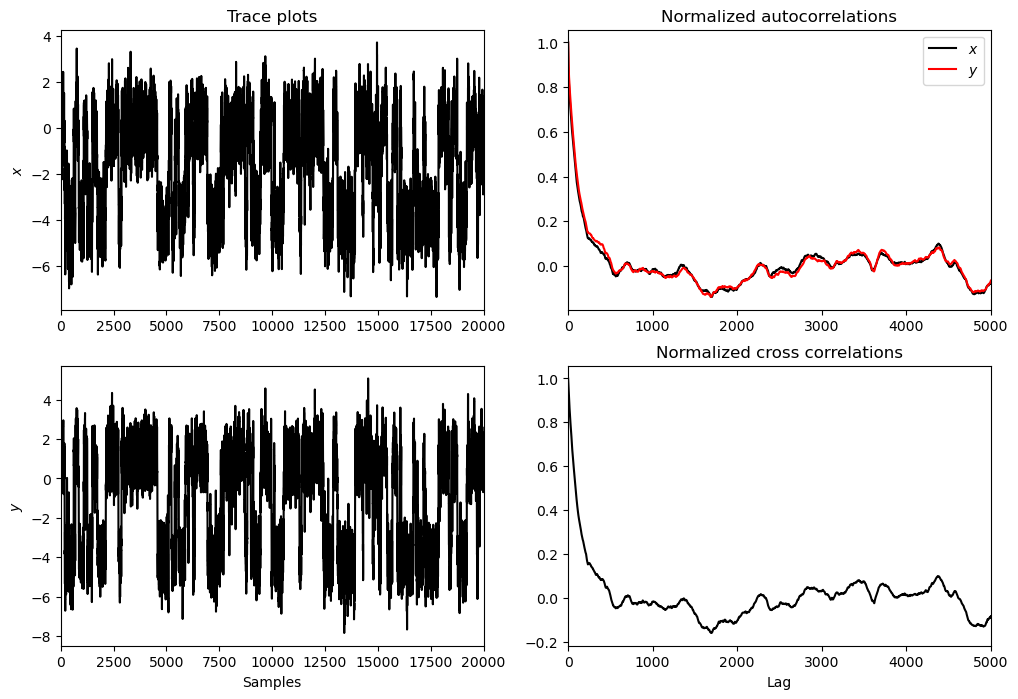

In [5]:
metropolis_hastings_samp(
    func = ptarget2,
    init_state = np.array([2,-6]),
    num_samples = 20000,
    prop_std = 1.0,
    max_lag = 5000,
)

Given that this target distribution is not a "badly" multimodal function (with distinctive and close peaks that produce large and easily identifiable valleys) [6], the sampler has still been able to present acceptable results, computing both modes for the most part, even with relative struggle and slightly distant initial state. However, two problems have arisen, making the sampling less than ideal, such as the unmatched height of the peaks in the histograms, and the now relevant necessity of an adequate number of samples to allow the walker to move between the different modes enough times to properly sample them. This last complication can be observed in the the trace plots, where the jumping between modes is apparent, and also in the autocorrelations and cross correlations plots, where their almost identical agitated behavior shows a high correlation between both traces. As for the convergence speed and acceptance ratio, they are mostly of the same quality as in the previous distribution.

### Anisotropic distribution case

Starting standard Metropolis-Hastings MCMC sampling...
Sampled function: <function ptarget3 at 0x000001EC3BDFA020>
Initial position: [-1  1]
Number of samples: 50000
Proposal standard deviation: 1.0
Running sampling...


  0%|          | 0/50000 [00:00<?, ?it/s]C:\Users\lucas\AppData\Local\Temp\ipykernel_13588\3864022817.py:152: RuntimeWarning: invalid value encountered in divide
  dist_func(*cand_state)/dist_func(*curr_state)
C:\Users\lucas\AppData\Local\Temp\ipykernel_13588\3864022817.py:152: RuntimeWarning: divide by zero encountered in divide
  dist_func(*cand_state)/dist_func(*curr_state)
100%|██████████| 50000/50000 [00:01<00:00, 38664.15it/s]


Results:
Sampling time: 1.295485019683838 s
Sampling time per sample: 2.5909700393676757e-05 s/sample
Sampling time per sample & acceptance ratio: 0.02643846978946608 s/(sample*acceptance_ratio)
Acceptance ratio: 0.00098
Generating plots...


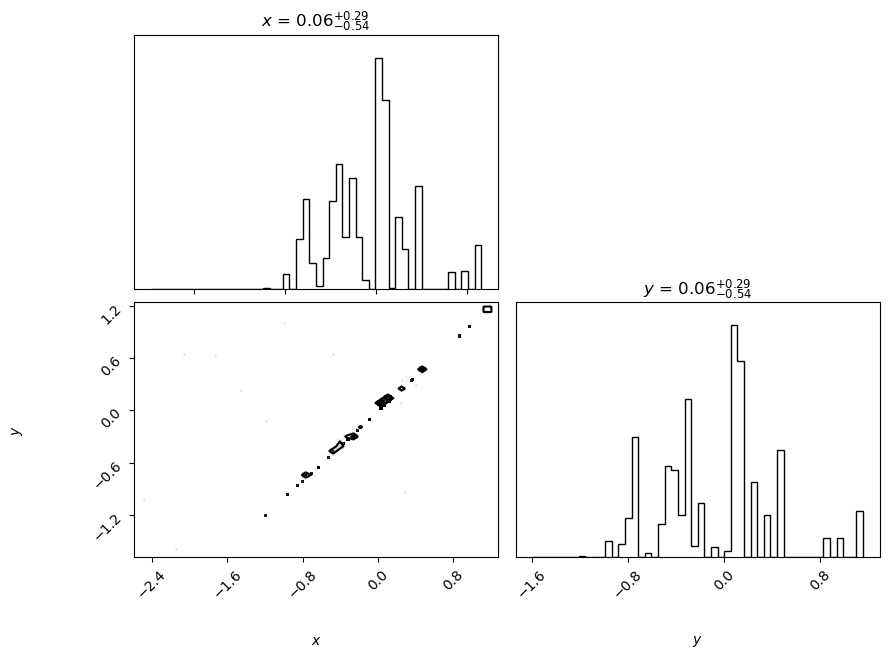

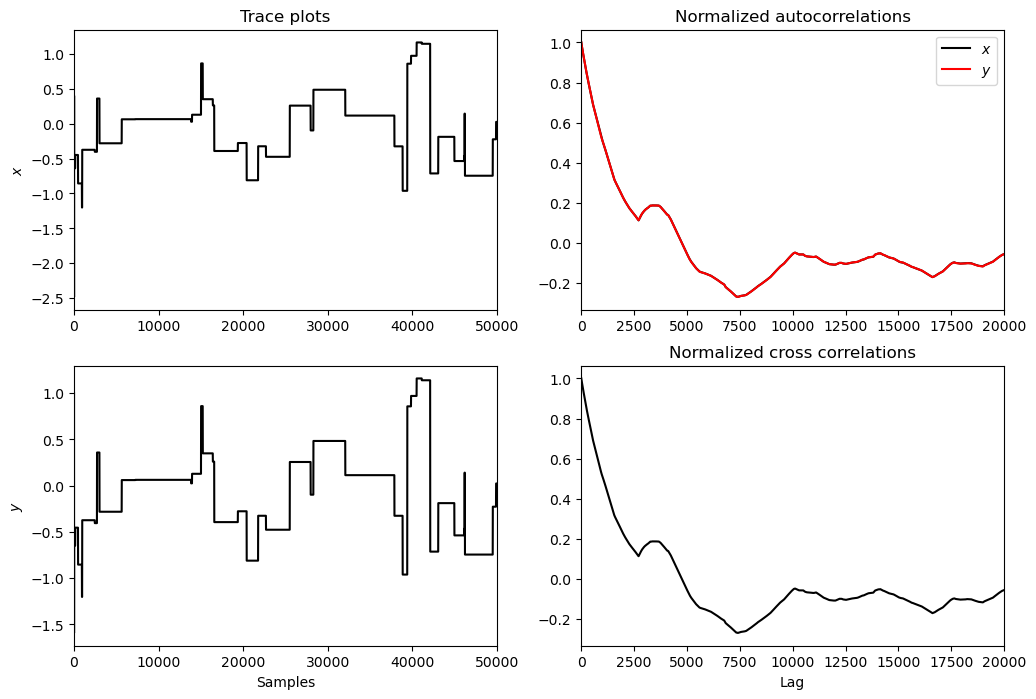

In [10]:
metropolis_hastings_samp(
    func = ptarget3,
    init_state = np.array([-1,1]),
    num_samples = 50000,
    prop_std = 1.0,
    max_lag = 20000
)

The clear challenge for this sampler to adequately map the distribution is evident and it is due to the narrow and anisotropic presentation of this particular distribution when only a symmetric proposal is given, resulting in an insufficient, inconsistent, and slow-converging outcome (even if burn-in steps are included), requiring the sampler to be run multiple times with favorable initial states, as well as taking into account prior considerations mentioned previously, to obtain a minimal resemblance of the target distribution. Furthermore, the acceptance ratio is extremely low, and the traces and correlation plots are highly correlated (fairly identical).

## Affine-invariant ensemble MCMC (emcee) algorithm

Following the testing and the subsequent problems with the third distribution of the standard M-H MCMC algorithm, it is understandable that a more adequate sampling algorithm is needed. This method can be obtained by observing that the anisotropic distribution can be simplified with an affine transformation such as $x^{\prime} = \frac{x - y}{\sqrt{\epsilon}}$ and $y^{\prime} = x + y$, which encourages the search for affine-invariant algorithms that perform well independently of coordinate choice and, therefore, are not affected by covariances between variables [4]. That is why the emcee algorithm is introduced and highlights its importance in this study.

Before presenting its results, it should be noted that, due to the utilization of more than one walker, the trace plots represent each walker with a different color, and the autocorrelation plot shows the walkers in only two colors, one for each dimension.

### Single bivariate Gaussian case

Starting affine-invariant ensemble MCMC (emcee) sampling...
Sampled function: <function log_prob1 at 0x000001EC3BDF9F80>
Number of walkers: 14
Number of burn in steps: 1
Number of steps: 8000
Running sampling...
Results:
Sampling time: 12.78268051147461 s
Sampling time per step: 0.001597835063934326 s/step
Mean acceptance ratio: 0.715
Mean autocorrelation time: 32.437 steps
Generating plots...


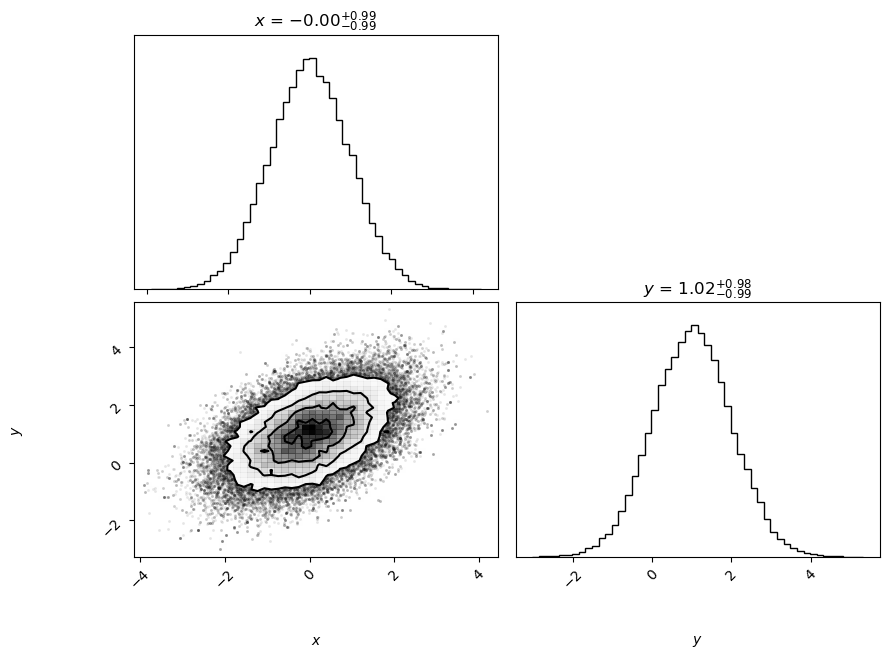

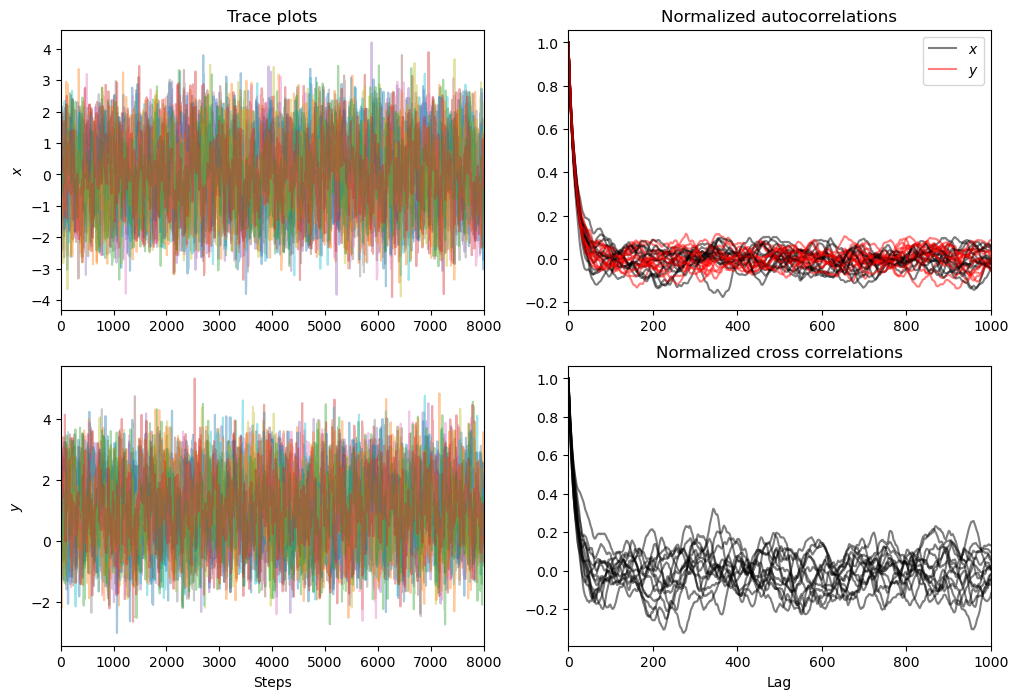

In [11]:
emcee_samp(
    log_prob1,
    [mean,var],
    ndim = 2,
    num_walkers = 14,
    burn_in_steps = 1,
    steps = 8000,
    max_lag = 1000
)

A major improvement can be observed in respect to the M-H MCMC sampling algorithm case, with more polished results (including no relevant number of burn-in steps, not-recommended [4] small number of walkers only for visualization issues, and a smaller number of steps overall), slightly quicker convergence, and a considerably higher acceptance ratio. This target distribution has posed no complications for the emcee algorithm.

### Double bivariate Gaussian case

Starting affine-invariant ensemble MCMC (emcee) sampling...
Sampled function: <function log_prob2 at 0x000001EC3BDFA0C0>
Number of walkers: 14
Number of burn in steps: 1
Number of steps: 8000
Running sampling...
Results:
Sampling time: 20.310804843902588 s
Sampling time per step: 0.0025388506054878236 s/step
Mean acceptance ratio: 0.577
Mean autocorrelation time: 111.792 steps
Generating plots...


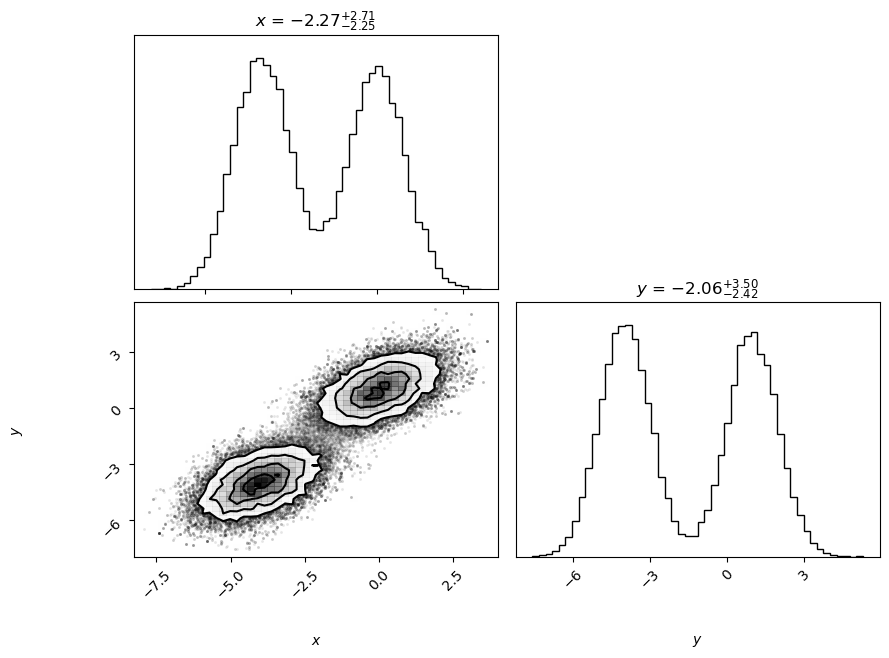

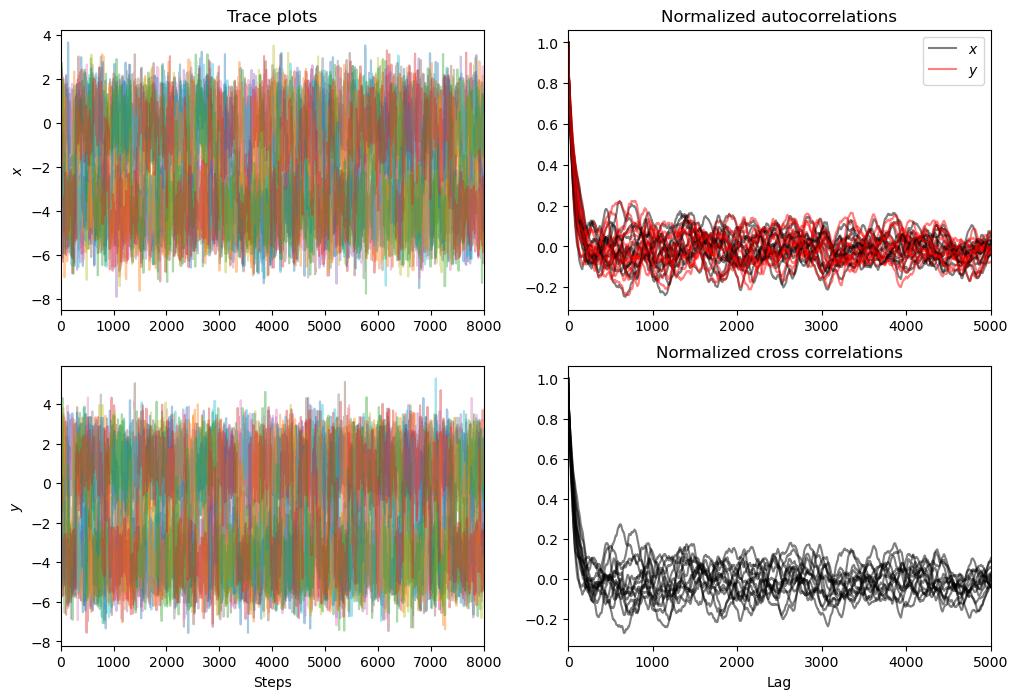

In [12]:
emcee_samp(
    log_prob2, 
    [mean1,var1,mean2,var2],
    ndim = 2,
    num_walkers = 14,
    burn_in_steps = 1,
    steps = 8000,
    max_lag = 5000
)

Once again, with similar parameters as in the last distribution, the emcee algorithm provides easily and effortlessly an enhancement over the M-H MCMC results; however, it is of slightly lesser magnitude than in the single bivariate case, with mostly the same acceptance ratio, convergence rate, and hopping between modes as in the M-H MCMC case.

### Anisotropic distribution case

Starting affine-invariant ensemble MCMC (emcee) sampling...
Sampled function: <function log_prob3 at 0x000001EC3BDFA200>
Number of walkers: 14
Number of burn in steps: 150
Number of steps: 8000
Running sampling...
Results:
Sampling time: 3.0263326168060303 s
Sampling time per step: 0.0003782915771007538 s/step
Mean acceptance ratio: 0.715
Mean autocorrelation time: 33.979 steps
Generating plots...


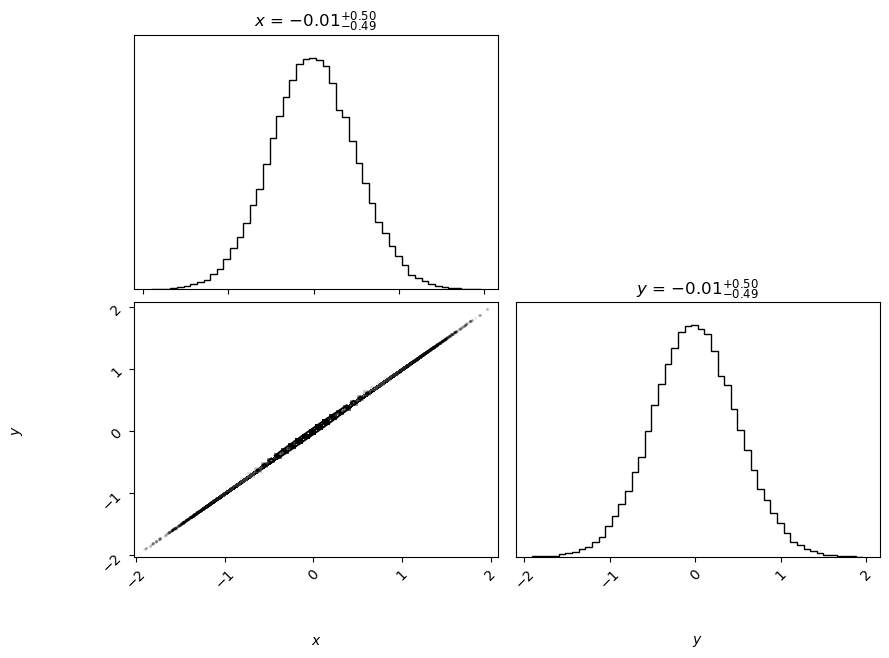

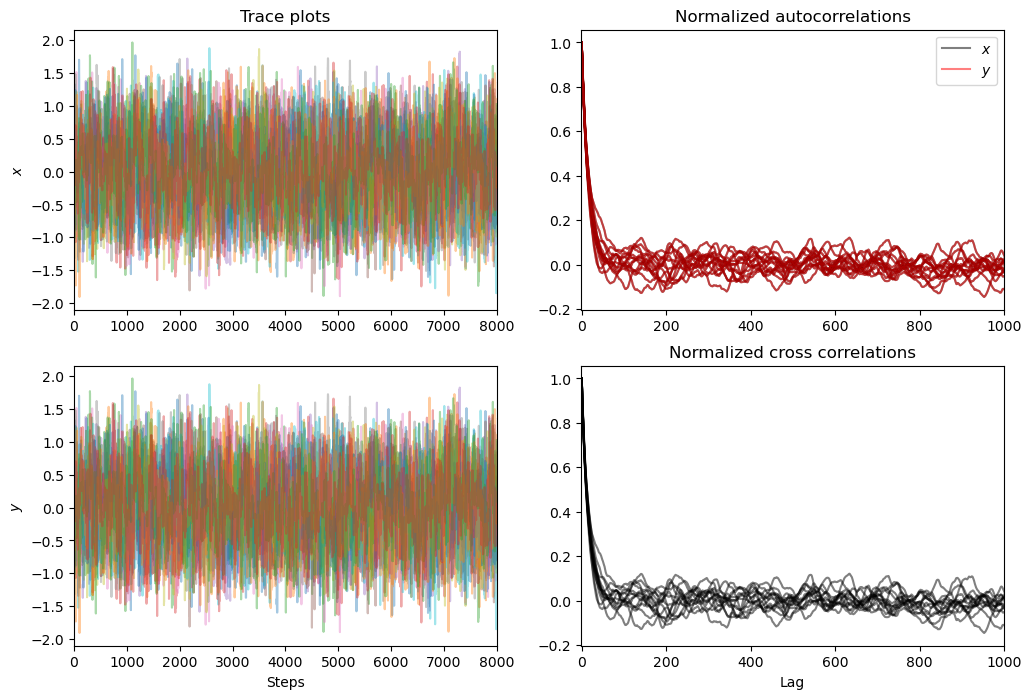

In [13]:
emcee_samp(
    log_prob3,
    eps,
    ndim = 2,
    num_walkers = 14,
    burn_in_steps = 150,
    steps = 8000,
    max_lag = 1000
)

As already expected, in this last target distribution, the emcee truly shines compared to the M-H MCMC, achieving, without huge complications, a largely clean and optimal outcome of the anisotropic distribution (with some burn-in steps needed) with autocorrelation time and acceptance ratio similar to the single bivariate case.

## Hamiltonian MCMC algorithm

Lastly, as a general alternative to previous methods, the Hamiltonian MCMC has, in principle, the advantage of being able to use informed proposal distributions for the sampling using first-order gradients, resulting in faster convergence in complex target distributions compared to the simpler M-H MCMC sampling [10]. For this purpose, the same propositions and initial states have been chosen as for the M-H MCMC, with varying step adjustment $\epsilon$ values to accomodate the jumps between modes.

### Single bivariate Gaussian case

Starting Hamiltonian MCMC sampling...
Sampled function: <function log_prob1_hmc at 0x000001EC3BDFA5C0>
Initial position: [-4  4]
Number of samples: 20000
Step adjustment in integrator: 0.5
Running sampling...
Results:
Sampling time: 16.223811149597168 s
Sampling time per sample: 0.0008111905574798584 s/sample
Generating plots...


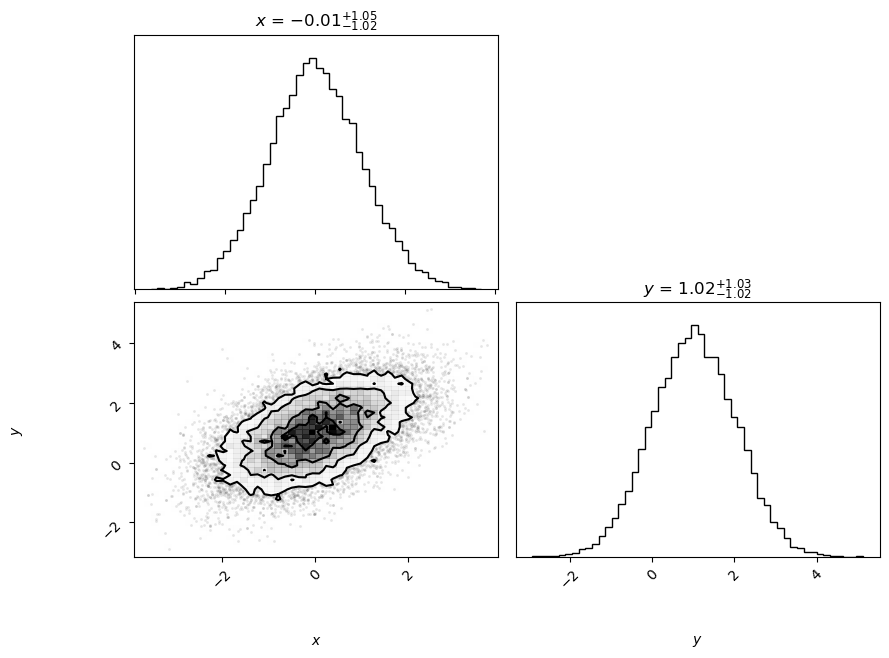

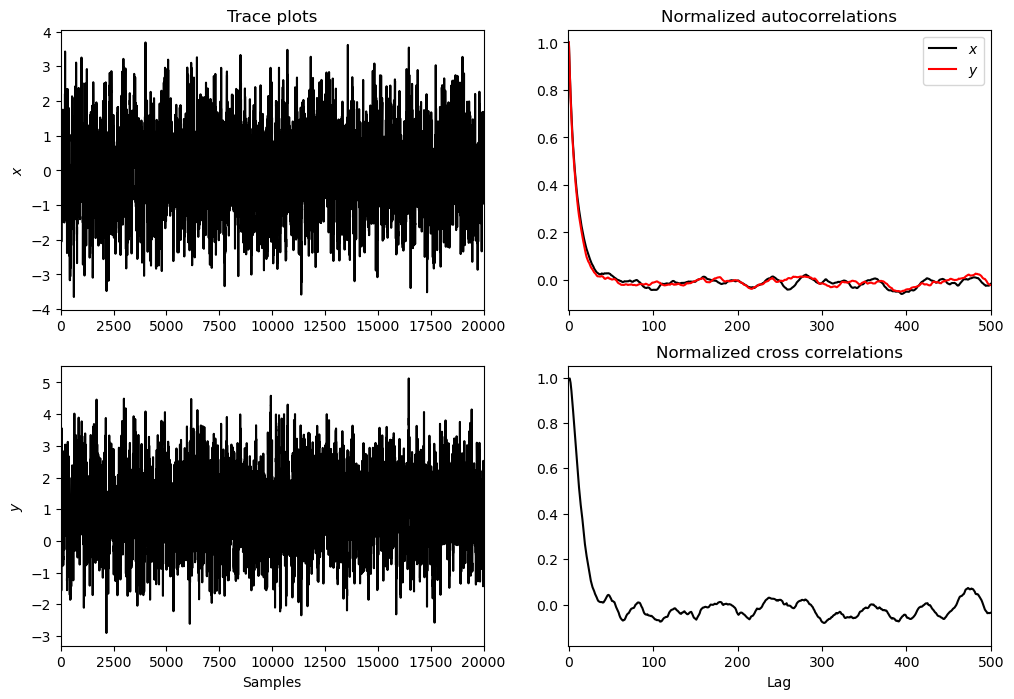

In [14]:
hmc_samp(
    log_prob_func = log_prob1_hmc,
    init_state = np.array([-4,4]),
    args = (mean,var),
    num_samples = 20000, 
    epsilon = 0.5, 
    max_lag = 500
)

It can be observed that the Hamiltonian MCMC correctly and easily samples the single bivariate distribution, yielding results of equal quality to those of the M-H MCMC ones, but, unfortunately, with a slower computation time.

### Double bivariate Gaussian case

Starting Hamiltonian MCMC sampling...
Sampled function: <function log_prob2_hmc at 0x000001EC3BDFA660>
Initial position: [ 2 -6]
Number of samples: 20000
Step adjustment in integrator: 1.0
Running sampling...
Results:
Sampling time: 32.3038489818573 s
Sampling time per sample: 0.001615192449092865 s/sample
Generating plots...


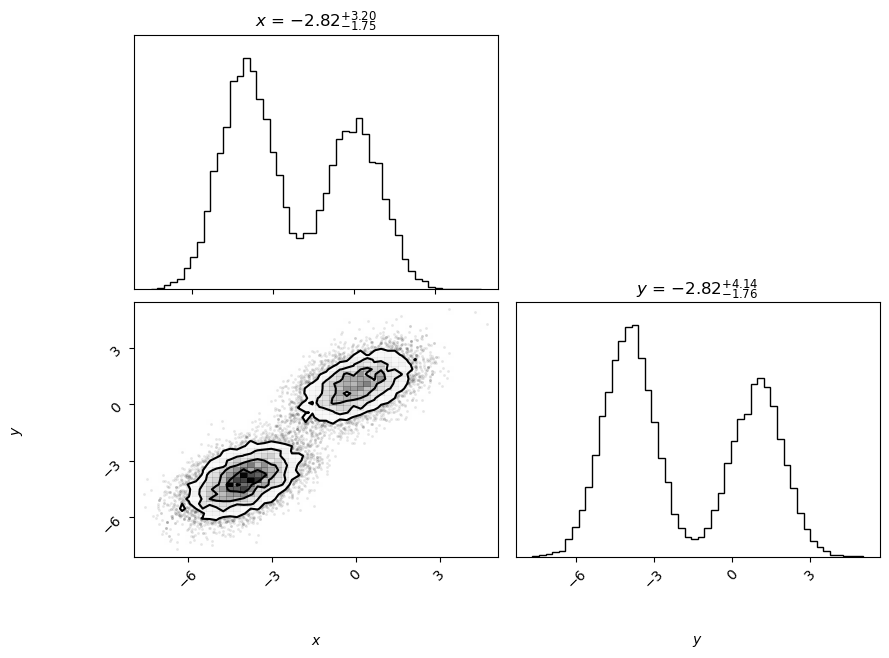

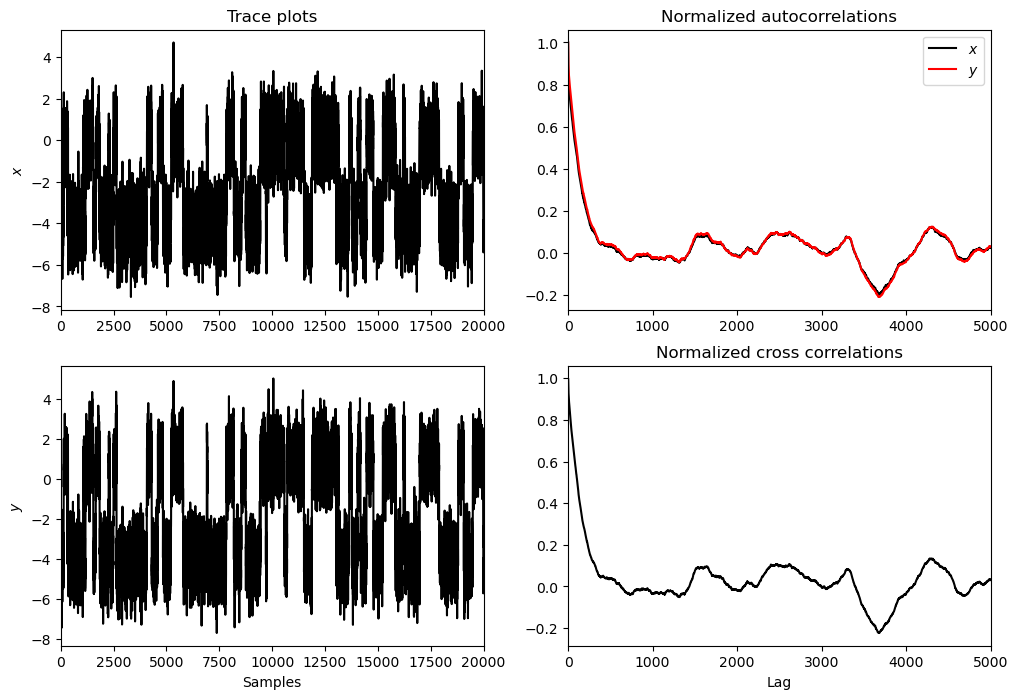

In [15]:
hmc_samp(
    log_prob_func = log_prob2_hmc,
    init_state = np.array([2,-6]),
    args = (mean1,var1,mean2,var2),
    num_samples = 20000,
    epsilon = 1.0,
    max_lag = 5000
)

As already anticipated, the Hamiltonian MCMC is able to obtain the double bivariate distribution successfully and without major difficulties (with a large enough $\epsilon$ to move between modes comfortably), granting an outcome of similar nature to the one from the M-H MCMC, only with more computation and autocorrelation times needed.

### Anisotropic distribution case

Starting Hamiltonian MCMC sampling...
Sampled function: <function log_prob3_hmc at 0x000001EC3BDFA520>
Initial position: [0 0]
Number of samples: 300000
Step adjustment in integrator: 0.005
Running sampling...
Results:
Sampling time: 6.802116632461548 s
Sampling time per sample: 2.267372210820516e-05 s/sample
Generating plots...


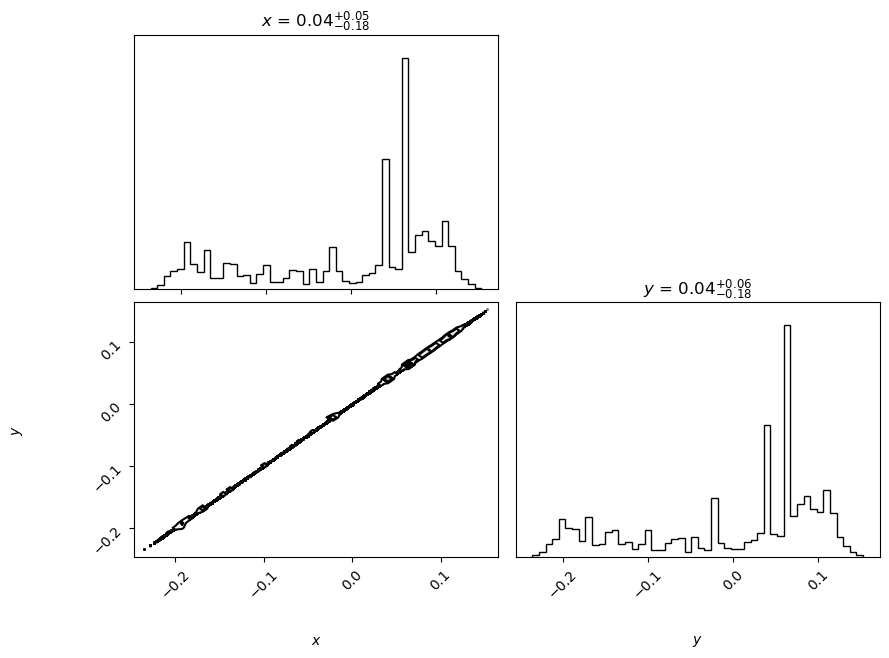

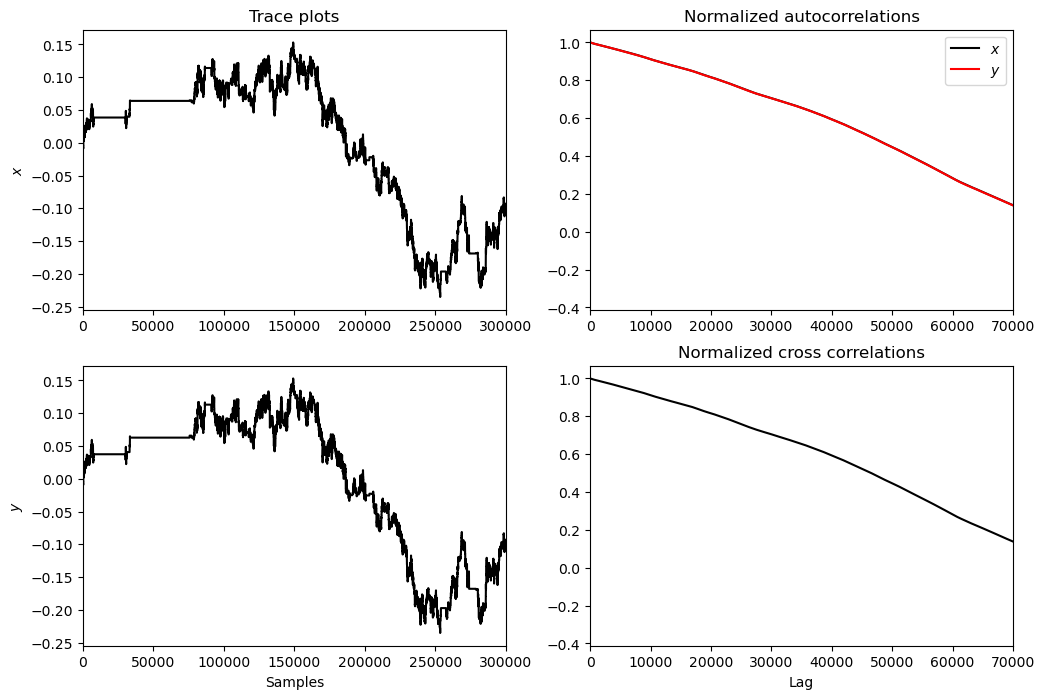

In [16]:
hmc_samp(
    log_prob_func = log_prob3_hmc,
    init_state = np.array([0,0]),
    args = (eps_hmc,),
    num_samples = 300000,
    epsilon = 0.005,
    max_lag = 70000
)

Finally, the Hamiltonian MCMC has an edge over the M-H MCMC but not over the emcee, being able to mostly sample the anisotropic distribution in a decent yet lacking manner with subpar autocorrelation and cross correlation rates using a large enough number of samples and a small enough $\epsilon$ value.

# References

[1] Cyrille Rossant. Computing the autocorrelation of a time series. https://ipython-books.github.io/103-computing-the-autocorrelation-of-a-time-series/. Accessed the 18/06/25.

[2] Dan Foreman-Mackey. corner.py. https://corner.readthedocs.io/en/latest/. Accessed the 18/06/25.

[3] Wikipedia. Multivariate normal distribution. 

https://en.wikipedia.org/wiki/Multivariate_normal_distribution. 

Accessed the 18/06/25.

[4] Daniel Foreman-Mackey, David W. Hogg, Dustin Lang, and Jonathan Goodman. emcee: The mcmc hammer. Publications of the Astronomical Society of the Pacific, 125(925):306–312, March 2013. https://arxiv.org/abs/1202.3665.

[5] Peter Mann (University of St Andrews). Markov Chain Monte Carlo: algorithms. https://petermann665964838.wordpress.com/. Accessed the 18/06/25.

[6] David W. Hogg and Daniel Foreman-Mackey. Data analysis recipes: Using markov chain monte carlo. *The Astrophysical Journal Supplement Series*, 236(1):11, May 2018.

[7] Foreman-Mackey et al., (2019). emcee v3: A Python ensemble sampling toolkit for affine-invariant MCMC. *Journal of Open Source Software*, 4(43), 1864, https://doi.org/10.21105/joss.01864.

[8] emcee. User Guide and tutorials. https://emcee.readthedocs.io/en/stable/. Accessed the 18/06/25.

[9] Simon Duane, A.D. Kennedy, Brian J. Pendleton, and Duncan Roweth. Hybrid monte carlo. *Physics Letters B*, 195(2):216–222, 1987.

[10] Robert T. McGibbon. pyhmc: Hamiltonain Monte Carlo in Python. https://pythonhosted.org/pyhmc/. Accessed the 18/06/25.

[11] Michael Betancourt. A conceptual introduction to hamiltonian monte carlo, 2018.